## 1124 가사 이진 감정 분류 모델

In [79]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
from konlpy.tag import Okt  
okt = Okt() 
import tensorflow as tf
import numpy as np
from collections import Counter
from konlpy.tag import Komoran
komoran = Komoran()
from wordcloud import WordCloud
import matplotlib.pyplot as plt


import urllib.request
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline
from string import punctuation
import warnings
warnings.filterwarnings('ignore')

In [34]:
df = pd.read_csv('./z_save/total_playlist.csv')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27927 entries, 0 to 27926
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   song_id     27927 non-null  int64 
 1   song_name   27927 non-null  object
 2   artist      27927 non-null  object
 3   album       27926 non-null  object
 4   Like_Count  27918 non-null  object
 5   Lyric       27894 non-null  object
 6   cover_url   27906 non-null  object
 7   tags        27906 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.7+ MB


In [37]:
print(len(df.Lyric)) # 데이터 개수

27894


## word columns

In [38]:
# 불용어 단어 (가사 빈도수 높은 + 감정분류와 무관한 단어 추가 중)
stop_w = ['all','이렇게','네가','있는','니가','없는','너의','너무','그런',
          'oh','whoo','tuesday','내가','너를','나를','we','this','the','그렇게',
          'so','am','baby','and','can','you','much','me','for','go','in',
          '은', '는', '이', '가', '하',
          'know','no','of','let','my','사랑','수','너','내','나','그','난','봐','돼','건','모든',
          '날','널','수','것','못','말','넌','젠','하나','정말','알','여기','우리','그대','다시',
          '때','아','더','게','또','채','일','걸','누구','나는','너는','라면','같아','있어','지금',
          '의','가','보','들','좀','잘','걍','과','도','를','으로','우린',
          '자','에','와','한','하다','네','있다','나의','해','다','내게','왜','거야']

In [39]:
words = []
for sent in df['Lyric'].tolist():
    sent_s = []
    sent_s.append(sent.split())
    for word in sent_s:
        if word not in stop_w:
            words.append(word)

In [41]:
df['words'] = words
df.head(3)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,words
0,30392514,bath,offonoff (오프온오프),bath,"[5,781]",거긴 날씨가 어때 나의 하늘과 밤엔 자꾸 떠오르는 기억이 계속 내게 말을...,https://image.bugsm.co.kr/album/images/200/200...,"['국내', '힙합', '알앤비', '밤/새벽', '감각적인', '작업실', '몽환...","[거긴, 날씨가, 어때, 나의, 하늘과, 밤엔, 자꾸, 떠오르는, 기억이, 계속, ..."
1,30346372,Belief (millic remix),millic(밀릭),Belief,"[1,510]",Our belief for each other written on a page ...,https://image.bugsm.co.kr/album/images/200/200...,"['국내', '힙합', '알앤비', '밤/새벽', '감각적인', '작업실', '몽환...","[Our, belief, for, each, other, written, on, a..."
2,30061516,[권리없는 곡],아파치(Apachi),Toujours Youth Remix Album,[54],겁이 나 내게 아무 말이나 들려줘 Girl I'm tired LGBT ne...,https://image.bugsm.co.kr/album/images/200/200...,"['국내', '힙합', '알앤비', '밤/새벽', '감각적인', '작업실', '몽환...","[겁이, 나, 내게, 아무, 말이나, 들려줘, Girl, I'm, tired, LG..."


## 전처리

In [42]:
df['Lyric'] = df['Lyric'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
df[:5]

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,words
0,30392514,bath,offonoff (오프온오프),bath,"[5,781]",거긴 날씨가 어때 나의 하늘과 밤엔 자꾸 떠오르는 기억이 계속 내게 말을...,https://image.bugsm.co.kr/album/images/200/200...,"['국내', '힙합', '알앤비', '밤/새벽', '감각적인', '작업실', '몽환...","[거긴, 날씨가, 어때, 나의, 하늘과, 밤엔, 자꾸, 떠오르는, 기억이, 계속, ..."
1,30346372,Belief (millic remix),millic(밀릭),Belief,"[1,510]",...,https://image.bugsm.co.kr/album/images/200/200...,"['국내', '힙합', '알앤비', '밤/새벽', '감각적인', '작업실', '몽환...","[Our, belief, for, each, other, written, on, a..."
2,30061516,[권리없는 곡],아파치(Apachi),Toujours Youth Remix Album,[54],겁이 나 내게 아무 말이나 들려줘 순전히 아름다움 팍...,https://image.bugsm.co.kr/album/images/200/200...,"['국내', '힙합', '알앤비', '밤/새벽', '감각적인', '작업실', '몽환...","[겁이, 나, 내게, 아무, 말이나, 들려줘, Girl, I'm, tired, LG..."
3,30506160,Every,민제 (Minje),Boy II Man,[317],난 이 길...,https://image.bugsm.co.kr/album/images/200/200...,"['국내', '힙합', '알앤비', '밤/새벽', '감각적인', '작업실', '몽환...","[I, don't, know, what?, every, time, everythin..."
4,3988024,On & On (Prod. By The Quiett),육지담,언프리티 랩스타 Semi Final 2,[581],첨부터 길을 잃었던 아이 세상과 마주하기에 너무 어렸던 나이 너넨 모르겠지 에 웃는...,https://image.bugsm.co.kr/album/images/200/493...,"['국내', '힙합', '알앤비', '밤/새벽', '감각적인', '작업실', '몽환...","[첨부터, 길을, 잃었던, 아이, 세상과, 마주하기에, 너무, 어렸던, 나이, 너넨..."


In [43]:
df['Lyric'] = df['Lyric'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
df['Lyric'].replace('', np.nan, inplace=True)
print(df.isnull().sum())

song_id          0
song_name        0
artist           0
album            1
Like_Count       0
Lyric         1089
cover_url       12
tags            12
words            0
dtype: int64


In [44]:
df[df['Lyric'].isnull()] # 한국어가 아닌 가사 - NaN값인 노래들

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,words
1,30346372,Belief (millic remix),millic(밀릭),Belief,"[1,510]",NaN,https://image.bugsm.co.kr/album/images/200/200...,"['국내', '힙합', '알앤비', '밤/새벽', '감각적인', '작업실', '몽환...","[Our, belief, for, each, other, written, on, a..."
129,6077809,TITANIC (feat. Rich Brian),잭슨 (Jackson Wang),MIRRORS,[12],NaN,https://image.bugsm.co.kr/album/images/200/403...,"['국내', '가요', 'KPOP', '아이돌', '치명적인', '섹시한', '남자...","[I, got, your, girl, on, panic, Iced, out, my,..."
208,31642982,Sapphire Blue,Jiwoo,Maison,[58],NaN,https://image.bugsm.co.kr/album/images/200/202...,"['국내', '인디', '국내 인디', '알앤비', '그루브한', '밤/새벽', '...","[Twenty, one, miles, past, blue, Twenty, one, ..."
209,31760450,Thief,Mood & Feel(무드앤필),Thief,[114],NaN,https://image.bugsm.co.kr/album/images/200/202...,"['국내', '인디', '국내 인디', '알앤비', '그루브한', '밤/새벽', '...","[Something's, knocking, on, my, eyes, And, it,..."
211,31914612,Alone,미소(Miso),Alone,[532],NaN,https://image.bugsm.co.kr/album/images/200/203...,"['국내', '인디', '국내 인디', '알앤비', '그루브한', '밤/새벽', '...","[The, season, goes, you're, all, alone, Nowher..."
...,...,...,...,...,...,...,...,...,...
27495,3587989,Faithful,AMP,Glory Songs [Japan Special Edition],[207],NaN,https://image.bugsm.co.kr/album/images/200/439...,"['국내', '지치고 힘들때', '응원', '사회초년생', '취준/수험생']","[Never, give, up,, never, give, in, Never, let..."
27685,31624550,Don't Let Me Down,Alisha(알리샤),Don't Let Me Down,[50],NaN,https://image.bugsm.co.kr/album/images/200/202...,"['국내', '가요', '지치고 힘들때', '용기']","[I, know, you've, been, through, a, lot, latel..."
27696,32196832,Film out,방탄소년단,"BTS, THE BEST",[720],NaN,https://image.bugsm.co.kr/album/images/200/203...,"['국내', '발라드', '국내 발라드', '위로', '감성적인', '가요', '지...","[浮かび上がる君は, あまりに鮮やかで, まるでそこにいるかと, 手を伸ばすところで, ふっ..."
27720,32256360,Dear Son,박선예,마인 OST Part 4,[168],NaN,https://image.bugsm.co.kr/album/images/200/204...,"['국내', '인디', '지치고 힘들때', '위로', '국내 인디']","[I'm, about, to, cry, Cause, you're, standing,..."


In [45]:
df = df.dropna(how = 'any')

In [46]:
print('전처리 후 데이터의 개수 :',len(df))

전처리 후 데이터의 개수 : 26793


## 긍정 감정에 해당하는 곡 category (tag) : 
* 사랑/기쁨 or 
* 설렘/심쿵 or 
* 기분전환 or
* 썸 탈때 or
* 고백

In [54]:
jdf = df[df['tags'].str.contains('사랑/기쁨', na=False) | df['tags'].str.contains('셀렘/심쿵', na=False) | df['tags'].str.contains('기분전환', na=False) | df['tags'].str.contains('고백', na=False) | df['tags'].str.contains('썸 탈때', na=False)].drop_duplicates(['song_id','Lyric'], keep='first',inplace=False).reset_index(drop=True)

In [63]:
jdf['label'] = 1
jdf.head(1)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,words,label
0,5906518,Kiss,OSIXTWO,무궁무진,[12],뭐 하냐고 묻지 마 입술을 갖고 와줘 먹어브러 맛있어 아랫입술 ...,https://image.bugsm.co.kr/album/images/200/980...,"['국내', '힙합', '국내 랩/힙합', '침대송', '연인/커플', '밤/새벽'...","[Hold, me, tight, Feel, so, right, babe, I, ne...",1


In [66]:
jdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3564 entries, 0 to 3563
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   song_id     3564 non-null   int64 
 1   song_name   3564 non-null   object
 2   artist      3564 non-null   object
 3   album       3564 non-null   object
 4   Like_Count  3564 non-null   object
 5   Lyric       3564 non-null   object
 6   cover_url   3564 non-null   object
 7   tags        3564 non-null   object
 8   words       3564 non-null   object
 9   label       3564 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 278.6+ KB


## 부정 감정에 해당하는 곡 category (tag) : 
* 이별/슬픔 or
* 울고 싶을때 or
* 애절한 or
* 쓸쓸한

In [60]:
sdf = df[df['tags'].str.contains('이별/슬픔', na=False) | df['tags'].str.contains('울고 싶을때', na=False) | df['tags'].str.contains('애절한', na=False) | df['tags'].str.contains('쓸쓸한', na=False) | ].drop_duplicates(['song_id','Lyric'], keep='first',inplace=False).reset_index(drop=True)



In [64]:
sdf['label'] = 0
sdf.head(1)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,words,label
0,3078025,불편한 진실,이지영 (빅마마),The Lyrics (더 리릭스) - No.3,[313],현재 시간은 열두시 지금이 낮인지 밤인지 이게 제대로 된 삶인지 불편한 진실...,https://image.bugsm.co.kr/album/images/200/373...,"['국내', '이색테마', '이별/슬픔', '밤/새벽', '소울풀한']","[현재, 시간은, 열두시, 지금이, 낮인지, 밤인지, 이게, 제대로, 된, 삶인지,...",0


In [65]:
sdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3320 entries, 0 to 3319
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   song_id     3320 non-null   int64 
 1   song_name   3320 non-null   object
 2   artist      3320 non-null   object
 3   album       3320 non-null   object
 4   Like_Count  3320 non-null   object
 5   Lyric       3320 non-null   object
 6   cover_url   3320 non-null   object
 7   tags        3320 non-null   object
 8   words       3320 non-null   object
 9   label       3320 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 259.5+ KB


In [67]:
jsdf = sdf.append(jdf)
jsdf.reset_index(inplace=True)
jsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6884 entries, 0 to 6883
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       6884 non-null   int64 
 1   song_id     6884 non-null   int64 
 2   song_name   6884 non-null   object
 3   artist      6884 non-null   object
 4   album       6884 non-null   object
 5   Like_Count  6884 non-null   object
 6   Lyric       6884 non-null   object
 7   cover_url   6884 non-null   object
 8   tags        6884 non-null   object
 9   words       6884 non-null   object
 10  label       6884 non-null   int64 
dtypes: int64(3), object(8)
memory usage: 591.7+ KB


## 데이터 분리

In [71]:
train_data, test_data = train_test_split(
  jsdf,
  test_size = 0.25,
  random_state = 5
)

In [72]:
# 학습 데이터
X_train = []
for sentence in tqdm(train_data['Lyric']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_w] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████████████████████████████████████████████████████████████████████████| 5163/5163 [01:43<00:00, 49.99it/s]


In [73]:
# 테스트 데이터 
X_test = []
for sentence in tqdm(test_data['Lyric']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_w] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [00:33<00:00, 51.61it/s]


In [74]:
X_train[:1]

[['언제',
  '부턴',
  '가다',
  '맘',
  '을',
  '괴롭히다',
  '한순간',
  '눈',
  '을',
  '떼다',
  '수가',
  '없다',
  '뭘',
  '먹다',
  '자르다',
  '너무나',
  '예쁘다',
  '어떡하다',
  '귀엽다',
  '나르다',
  '웃다',
  '만의',
  '차갑다',
  '이미지',
  '얼마나',
  '따뜻하다',
  '만이',
  '느끼다',
  '어느새다',
  '계절',
  '속',
  '빠지다',
  '보다',
  '어느새다',
  '맘',
  '아무',
  '모르다',
  '입술',
  '닿다',
  '빨갛다',
  '니',
  '두',
  '뺨',
  '면',
  '충분하다',
  '그것',
  '만으로도',
  '단',
  '한번',
  '전화',
  '그냥',
  '적',
  '없다',
  '떨리다',
  '목',
  '막히다',
  '만',
  '번은',
  '고민',
  '말투',
  '예쁘다',
  '부탁',
  '그만하다',
  '자제',
  '잠',
  '들다',
  '내다',
  '짓다',
  '미소',
  '얼마나',
  '위험하다',
  '건지다',
  '숨',
  '멎다',
  '버리다',
  '같다',
  '어느새다',
  '계절',
  '속',
  '빠지다',
  '보다',
  '어느새다',
  '맘',
  '아무',
  '모르다',
  '입술',
  '닿다',
  '빨갛다',
  '니',
  '두',
  '뺨',
  '면',
  '충분하다',
  '그것',
  '만으로도',
  '칭찬',
  '없다',
  '만의',
  '만의',
  '되어다',
  '어느새다',
  '계절',
  '속',
  '빠지다',
  '보다',
  '어느새다',
  '맘',
  '따뜻하다',
  '맘',
  '내다',
  '취한',
  '같다',
  '어느새다',
  '맘',
  '아무',
  '모르다',
  '손',
  '을',
  '잡고',
  '길',
  '을',
  '함

## 정답 데이터 저장

In [75]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [76]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]
print(drop_train)

[]


In [77]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_test))
print(len(y_test))

5163
5163
1721
1721
1721
1721


## 정수 인코딩
* 모델이 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행
* 단어 집합이 생성되는 동시에 각 단어에 고유한 정수를 부여함
* 각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여되었기 때문에, <br>높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미함

In [81]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [82]:
# print(tokenizer.word_index)
# print(tokenizer.word_counts.items())

## 빈도수 확인 (3회 미만)

In [83]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [84]:
# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 11870
등장 빈도가 2번 이하인 희귀 단어의 수: 5310
단어 집합에서 희귀 단어의 비율: 44.734625105307494
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.1170550337628946


In [85]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 6561


단어 집합을 케라스 토크나이저의 인자로 넘겨주면, 케라스 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환

In [86]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### 정수 인코딩 확인

In [87]:
print(X_train[:1])

[[140, 1003, 30, 8, 1, 1034, 1175, 20, 1, 856, 168, 3, 362, 288, 1294, 348, 113, 208, 694, 12, 44, 246, 307, 5037, 314, 323, 448, 159, 316, 333, 32, 196, 2, 316, 8, 56, 11, 278, 247, 662, 15, 65, 2094, 105, 630, 767, 1574, 270, 150, 395, 82, 319, 3, 229, 738, 896, 5, 1999, 359, 653, 113, 1046, 864, 5038, 203, 52, 16, 503, 167, 314, 1231, 309, 181, 1126, 29, 6, 316, 333, 32, 196, 2, 316, 8, 56, 11, 278, 247, 662, 15, 65, 2094, 105, 630, 767, 1574, 3992, 3, 246, 246, 211, 316, 333, 32, 196, 2, 316, 8, 323, 8, 16, 1176, 6, 316, 8, 56, 11, 50, 1, 324, 99, 1, 48, 81, 630, 354, 2]]


## 패딩

가사의 최대 길이 : 358
가사의 평균 길이 : 117.39376331590161


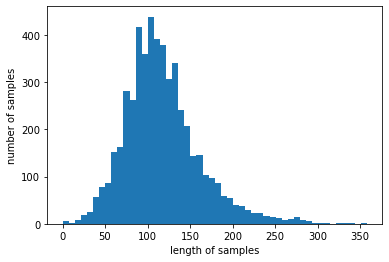

In [88]:
print('가사의 최대 길이 :',max(len(l) for l in X_train))
print('가사의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [89]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [93]:
max_len = 200
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 200 이하인 샘플의 비율: 95.09974820840597


## 모든 샘플의 길이를 max_len로 조정

In [94]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

---

## 모델 적용

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, LSTM, Embedding, Bidirectional
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [96]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stop_w] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 가사입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 가사입니다.\n".format((1 - score) * 100))

---

## Bidirectional(LSTM(N))
양방향 many-to-one LSTM
*  return_sequence=False (default) : 양방향 & many-to-one 유형
* 양방향(Bidirection) 재귀 모델은 시간적으로 앞의 데이터만 가지고는 올바른 예측을 할 수 없다는 문제점을 해결하기 위하여,<br> 정방향뿐 아닌 역방향의 전파까지도 실행시키는 것을 의미함
* LSTM에 return_sequence=True, Bidirectional이면서 TimeDistributed() 함수가 사용되면 양방향 many-to-many 유형

> https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

## T1
* model.add(Embedding(vocab_size, 300, mask_zero=True))
* model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
* loss: 0.1099 - acc: 0.9567 - val_loss: 0.8096 - val_acc: 0.7735
* 330s

In [110]:
model = Sequential()
model.add(Embedding(vocab_size, 300, mask_zero=True))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(1,activation='sigmoid')) # , activation='sigmoid'

In [99]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [100]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
65/65 [==============================] - 116s 2s/step - loss: 0.5328 - acc: 0.7354 - val_loss: 0.5032 - val_acc: 0.7890

Epoch 00001: val_acc improved from -inf to 0.78896, saving model to best_model.h5
Epoch 2/15
65/65 [==============================] - 118s 2s/step - loss: 0.3484 - acc: 0.8673 - val_loss: 0.5328 - val_acc: 0.7803

Epoch 00002: val_acc did not improve from 0.78896
Epoch 3/15
65/65 [==============================] - 121s 2s/step - loss: 0.2452 - acc: 0.9090 - val_loss: 0.5245 - val_acc: 0.7870

Epoch 00003: val_acc did not improve from 0.78896
Epoch 4/15
65/65 [==============================] - 125s 2s/step - loss: 0.1634 - acc: 0.9453 - val_loss: 0.6711 - val_acc: 0.7677

Epoch 00004: val_acc did not improve from 0.78896
Epoch 5/15
65/65 [==============================] - 119s 2s/step - loss: 0.1099 - acc: 0.9567 - val_loss: 0.8096 - val_acc: 0.7735

Epoch 00005: val_acc did not improve from 0.78896
Epoch 00005: early stopping


In [101]:
sentiment_predict('너를 만난 세상 슬픈 우연 속에서')

64.35% 확률로 긍정 가사입니다.



In [102]:
sentiment_predict('눈물이 흘러 이별인걸 알았어. 힘없이 돌아서던 너의 뒷모습을 바라보며')

97.48% 확률로 부정 가사입니다.



In [103]:
sentiment_predict('나는 나는 행복에 묻힐 거에요')

75.34% 확률로 부정 가사입니다.



In [104]:
sentiment_predict('눈을 뜨기 힘든 가을 보다 높은 저 하늘이 기분 좋아')

70.36% 확률로 긍정 가사입니다.



In [105]:
sentiment_predict('두 눈에 비친 너의 미소 지친 날 감싸듯 내 맘 비춰 소리없이 찾아와')

85.13% 확률로 긍정 가사입니다.



In [106]:
sentiment_predict('넌 그대로가 사랑이니까 이대로가 좋다 했지')

76.05% 확률로 긍정 가사입니다.



In [107]:
sentiment_predict('손을잡아 너와 함께 난 언제라도 따듯한 폭닥한 이불 널 보면 생각나')

84.47% 확률로 긍정 가사입니다.



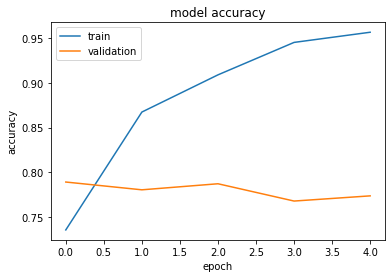

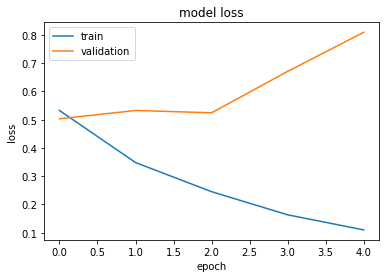

In [108]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## T2
* optimizer='adam', loss='binary_crossentropy', metrics=['acc']
* 1070 s

In [111]:
model = Sequential()
model.add(Embedding(vocab_size, 300, mask_zero=True))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(4,activation="relu"))
model.add(Dense(1,activation='sigmoid')) # , activation='sigmoid'

In [112]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [113]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
65/65 [==============================] - 164s 2s/step - loss: 0.6150 - acc: 0.6433 - val_loss: 0.5323 - val_acc: 0.7076

Epoch 00001: val_acc improved from -inf to 0.70765, saving model to best_model.h5
Epoch 2/15
65/65 [==============================] - 152s 2s/step - loss: 0.4524 - acc: 0.8017 - val_loss: 0.5298 - val_acc: 0.7754

Epoch 00002: val_acc improved from 0.70765 to 0.77541, saving model to best_model.h5
Epoch 3/15
65/65 [==============================] - 146s 2s/step - loss: 0.3555 - acc: 0.8620 - val_loss: 0.4792 - val_acc: 0.7890

Epoch 00003: val_acc improved from 0.77541 to 0.78896, saving model to best_model.h5
Epoch 4/15
65/65 [==============================] - 154s 2s/step - loss: 0.2697 - acc: 0.8966 - val_loss: 0.5049 - val_acc: 0.7996

Epoch 00004: val_acc improved from 0.78896 to 0.79961, saving model to best_model.h5
Epoch 5/15
65/65 [==============================] - 152s 2s/step - loss: 0.1926 - acc: 0.9266 - val_loss: 0.6076 - val_acc: 0.7938

Epo

In [114]:
sentiment_predict('너를 만난 세상 슬픈 우연 속에서')

93.38% 확률로 부정 가사입니다.



In [115]:
sentiment_predict('눈물이 흘러 이별인걸 알았어. 힘없이 돌아서던 너의 뒷모습을 바라보며')

99.59% 확률로 부정 가사입니다.



In [116]:
sentiment_predict('나는 나는 행복에 묻힐 거에요')

64.30% 확률로 부정 가사입니다.



In [117]:
sentiment_predict('눈을 뜨기 힘든 가을 보다 높은 저 하늘이 기분 좋아')

81.43% 확률로 긍정 가사입니다.



In [118]:
sentiment_predict('두 눈에 비친 너의 미소 지친 날 감싸듯 내 맘 비춰 소리없이 찾아와')

65.21% 확률로 부정 가사입니다.



In [119]:
sentiment_predict('넌 그대로가 사랑이니까 이대로가 좋다 했지')

54.75% 확률로 긍정 가사입니다.



In [120]:
sentiment_predict('손을잡아 너와 함께 난 언제라도 따듯한 폭닥한 이불 널 보면 생각나')

62.49% 확률로 긍정 가사입니다.



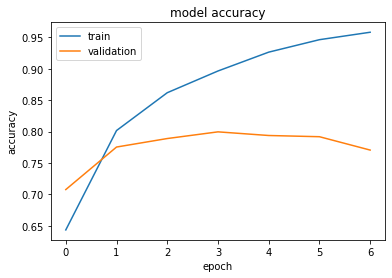

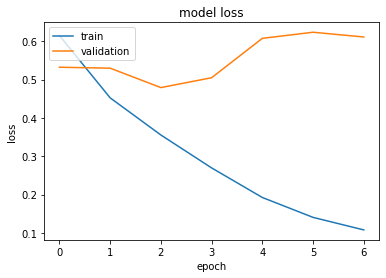

In [122]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 모델 저장

In [121]:
# creates a HDF5 file 'my_model.h5'
model.save('models/biLSTM_w2v_1124_2.h5')

In [185]:
from keras.models import load_model
predictor = load_model('models/biLSTM_w2v.h5')